Nama: Hari Andrew

# Time-Series ARIMA

In [1]:
# Data Preprocessing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [2]:
df_customer = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df_product = pd.read_csv('Case Study - Product.csv', delimiter=';')
df_store = pd.read_csv('Case Study - Store.csv', delimiter=';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [3]:
df_customer.tail()

,CustomerID,Age,Gender,Marital Status,Income
442,443,33,1,NaN,"9,28"
443,444,53,0,Married,"15,31"
444,445,51,0,Married,"14,48"
445,446,57,0,Married,"7,81"
446,447,54,1,Married,"20,37"


In [4]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [5]:
df_customer.duplicated().sum()

0

In [6]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [7]:
df_customer = df_customer.dropna()

In [8]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [9]:
df_customer.dtypes

CustomerID         int64
Age                int64
Gender             int64
Marital Status    object
Income            object
dtype: object

In [10]:
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')

<ipython-input-10-b5c38430cb44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')


In [11]:
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

In [12]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

<ipython-input-12-433e6c690dce>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])


In [13]:
df_transaction.tail()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
5015,TR54423,243,2022-12-31,P10,15000,5,75000,3
5016,TR5604,271,2022-12-31,P2,3200,4,12800,9
5017,TR81224,52,2022-12-31,P7,9400,6,56400,9
5018,TR85016,18,2022-12-31,P8,16000,3,48000,13
5019,TR85684,55,2022-12-31,P8,16000,1,16000,6


In [14]:
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [15]:
df_transaction [df_transaction['TransactionID'] == 'TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


Merge All Data

In [16]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])

In [17]:
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])

In [18]:
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [19]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [20]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty': 'sum'
}).reset_index()

In [21]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


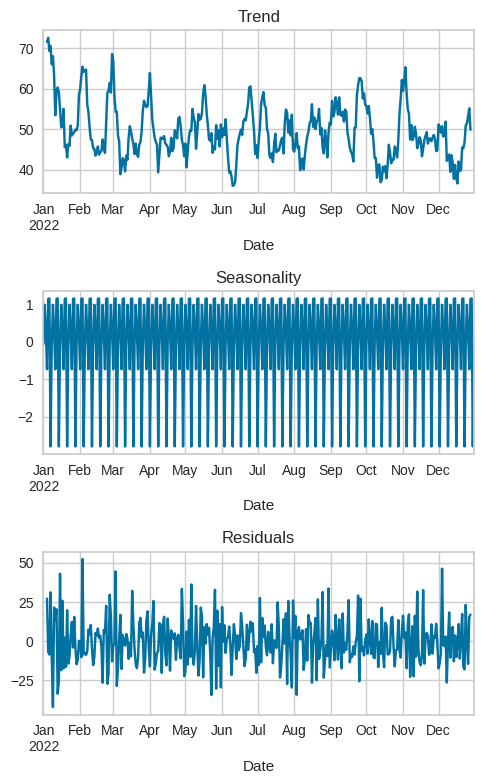

In [22]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(5,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [23]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.091514
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [24]:
# train test split
cut_off = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi[:cut_off] # 80%
df_test = df_regresi[cut_off:].reset_index(drop=True) # 20%
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [25]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,24
289,2022-10-17,53
290,2022-10-18,47


In [26]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,40


<Axes: xlabel='Date', ylabel='Qty'>

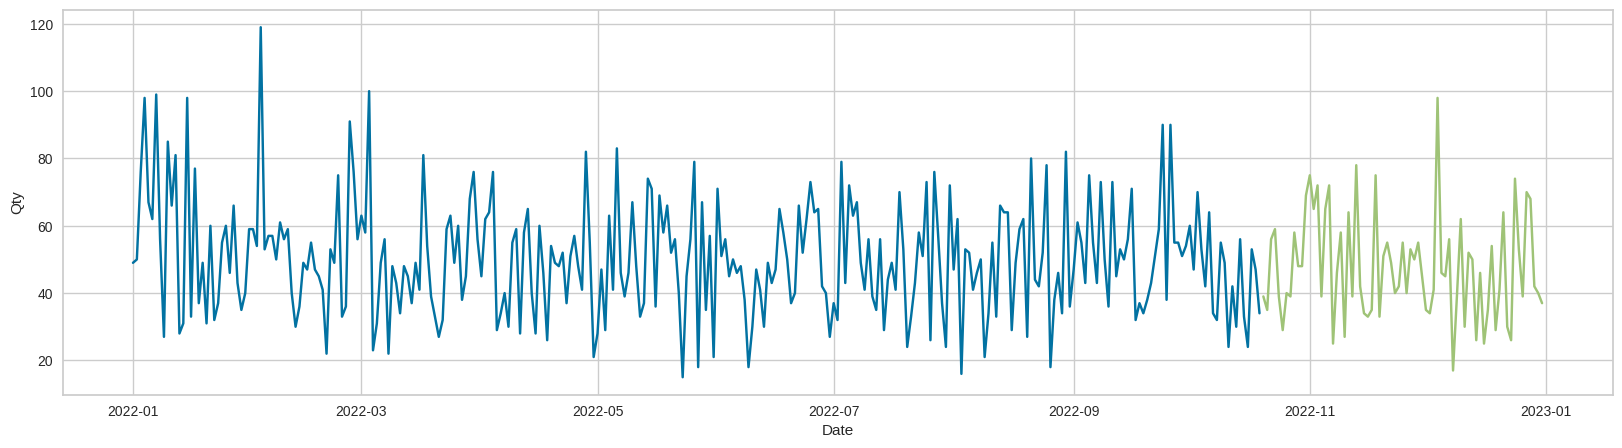

In [27]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

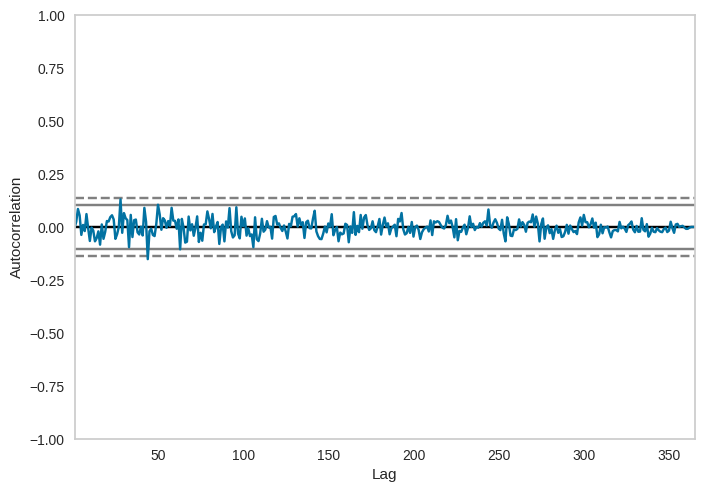

In [28]:
autocorrelation_plot(df_regresi['Qty'])

In [29]:
# function for rmse and eval
def rmse(y_actual, y_pred):
  print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

RMSE value 15.856695195531067
MAE value 12.625558626204052


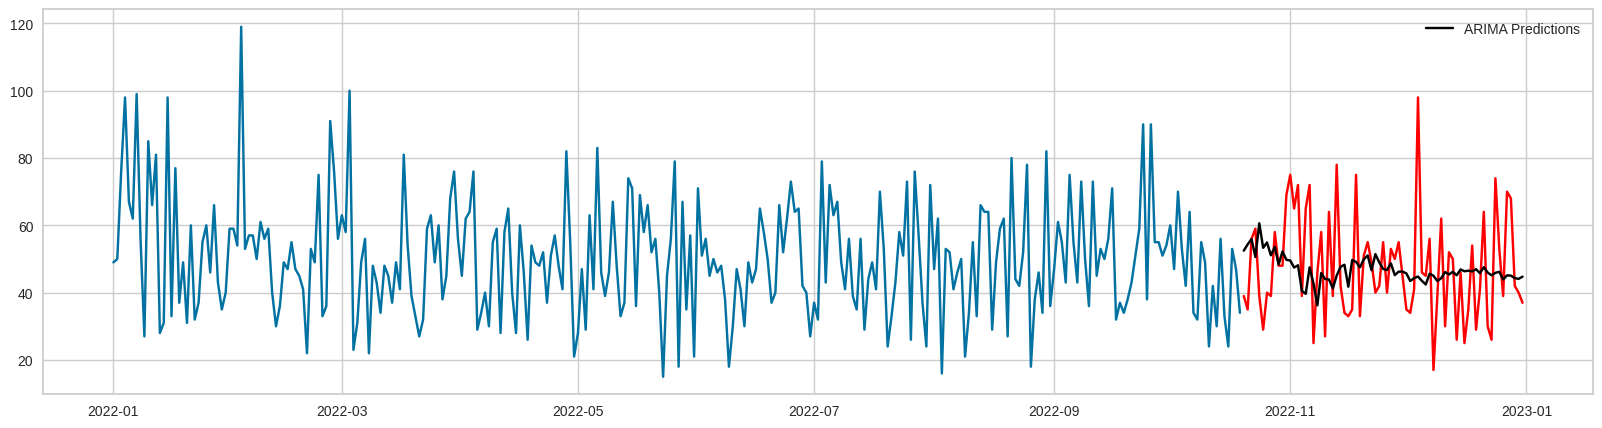

In [30]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()


# KMeans Clustering

In [31]:
df_merge.tail()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
4971,TR69555,221,2022-01-08,P4,12000,3,36000,4,23,1,Single,7.50,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4972,TR21587,425,2022-10-17,P4,12000,1,12000,4,58,1,Married,7.22,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4973,TR51183,409,2022-07-19,P4,12000,1,12000,4,47,0,Married,28.23,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4974,TR14963,374,2022-12-16,P4,12000,5,60000,4,32,0,Single,5.40,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4975,TR40750,271,2022-11-30,P4,12000,3,36000,4,29,0,Married,4.74,Potato Chip,Gita Ginara,Gita,General Trade,-6.966667,110.416664


<ipython-input-32-5e35fbe538e1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_merge.corr(), annot=True, cmap='GnBu')


<Axes: >

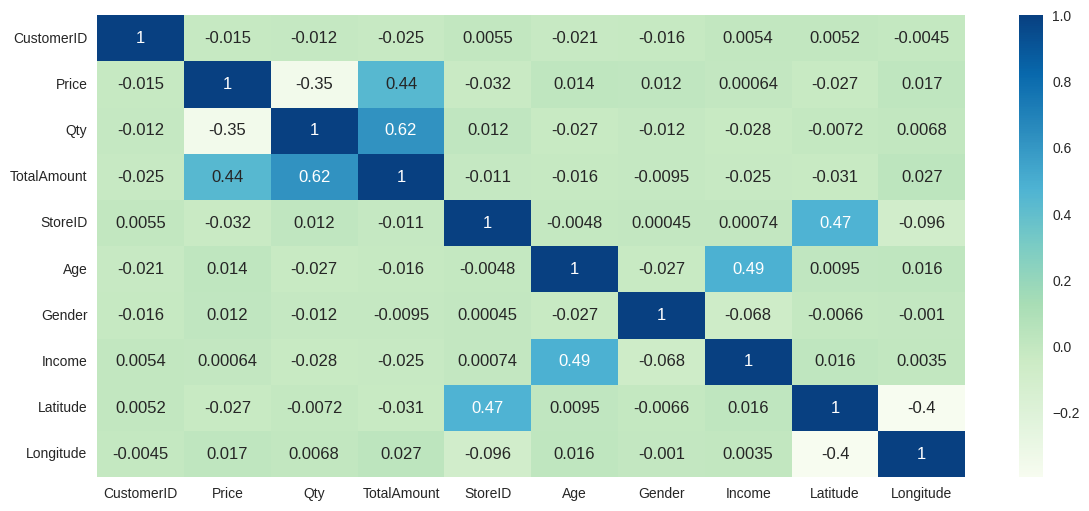

In [32]:
plt.figure(figsize=(14,6))
sns.heatmap(df_merge.corr(), annot=True, cmap='GnBu')

In [33]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    # 'TotalAmount': 'sum',
    'Age': 'first'
}).reset_index().rename(columns={
    'TransactionID': 'count_transaction',
    'Qty': 'total_qty'
})

In [34]:
df_cluster.head()

,CustomerID,count_transaction,total_qty,Age
0,1,17,60,55
1,2,13,57,60
2,3,15,56,32
3,4,10,46,31
4,5,7,27,58


In [35]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

data_cluster_normalize

array([[0.20444864, 0.72158345, 0.66145149],
       [0.15518033, 0.68040606, 0.71621691],
       [0.22651995, 0.84567449, 0.48324256],
       ...,
       [0.20717044, 0.78264389, 0.58698292],
       [0.15351993, 0.58616699, 0.79551234],
       [0.18668837, 0.60314704, 0.77547476]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

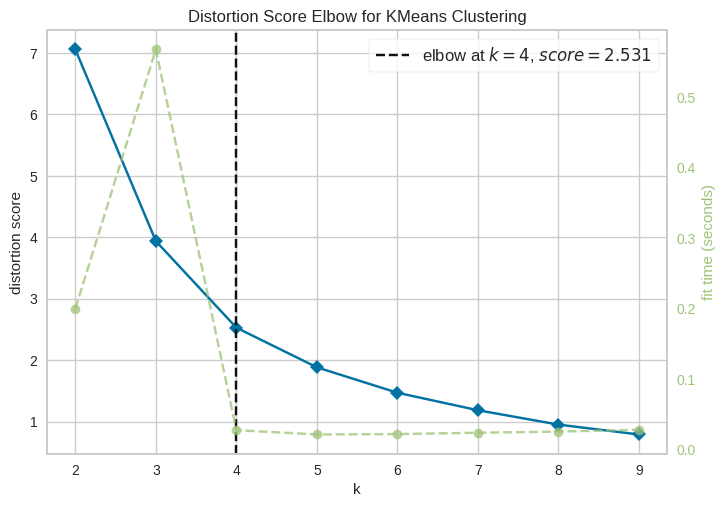

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data_cluster_normalize)        # Fit the data to the visualizer
visualizer.show()

In [37]:
K = range(2,10)
fits=[]
score=[]

for k in K:
  model = KMeans(n_clusters = k, random_state=42).fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<Axes: >

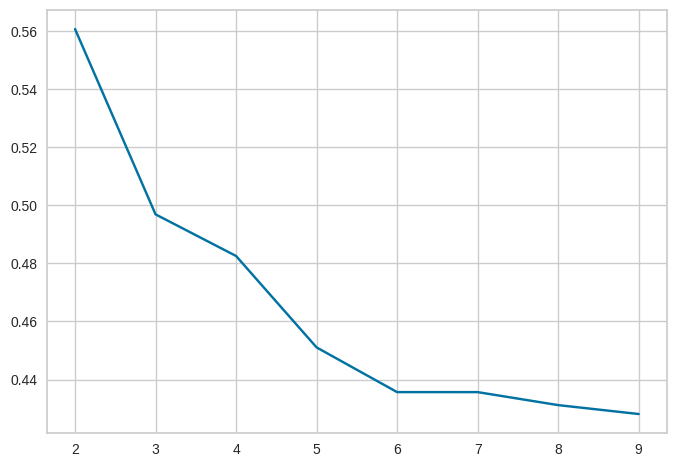

In [38]:
sns.lineplot(x=K, y=score)

In [39]:
fits[4]

KMeans(n_clusters=6, random_state=42)

In [40]:
df_cluster['cluster_label'] = fits[4].labels_

In [41]:
df_cluster

,CustomerID,count_transaction,total_qty,Age,cluster_label
0,1,17,60,55,0
1,2,13,57,60,4
2,3,15,56,32,5
3,4,10,46,31,5
4,5,7,27,58,1
...,...,...,...,...,...
439,442,13,37,42,4
440,444,18,62,53,0
441,445,18,68,51,0
442,446,11,42,57,2


In [42]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID': 'count',
    'count_transaction': 'mean',
    'total_qty': 'mean',
    'Age': 'mean'
})

,CustomerID,count_transaction,total_qty,Age
cluster_label,,,,
0,90,11.933333,44.633333,35.811111
1,51,7.411765,24.803922,50.862745
2,94,9.755319,33.755319,48.478723
3,30,14.900000,55.866667,20.600000
4,100,11.590000,40.820000,43.560000
5,79,12.670886,49.518987,29.632911


cluster 3 -> avg qty besar, age muda, kebutuhan banyak. (misal: anak muda masih banyak komsumtif)

cluster 1 -> avg qty kecil, age cukup tua, sehingga kebutuhan tidak terlalu banyak.